In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Splitting the train and evaluation set in 80% & 20% respectively
np_random = np.random.RandomState(seed=12345)
rand_unifs = np_random.uniform(0,1, size=df.shape[0])
division_thresh = np.percentile(rand_unifs, 80)
training_indicator = rand_unifs < division_thresh
eval_indicator = rand_unifs >= division_thresh

In [4]:
# Set training set

train_df = df[training_indicator].reset_index(drop=True)

# Set features matrix
train_features = train_df.loc[:,train_df.columns != 'Outcome'].values
train_labels = train_df['Outcome'].values

print(f'Train features matrix shape: {train_features.shape}')
print(f'Train Labels vector shape: {train_labels.shape}')

Train features matrix shape: (614, 8)
Train Labels vector shape: (614,)


In [5]:
# Set evaulation df

eval_df = df[eval_indicator].reset_index(drop=True)

# Set evaluation features matrix
eval_features = eval_df.loc[:,eval_df.columns != 'Outcome'].values

#Set evaluation features vector
eval_labels = eval_df['Outcome'].values

print(f'Evaluation features matrix shape: {eval_features.shape}')
print(f'Evaluation labels vector shape: {eval_labels.shape}')

Evaluation features matrix shape: (154, 8)
Evaluation labels vector shape: (154,)


In [6]:
# identify the missing values: Those are the ones with "0" entries in the "Blood Pressure," "Skin Thickness," "BMI," and "Age"  

train_df_with_nans = train_df.copy(deep=True)
eval_df_with_nans = eval_df.copy(deep=True)

# loop over the features (columns) that have missing values (0), and replacing with nans
for col_with_nans in ['BloodPressure', 'SkinThickness', 'BMI', 'Age']:
    train_df_with_nans[col_with_nans] = train_df_with_nans[col_with_nans].replace(0,np.nan)
    eval_df_with_nans[col_with_nans] = eval_df_with_nans[col_with_nans].replace(0, np.nan)
    
# Set the feature matrices for training & evaluation sets

train_features_with_nans = train_df_with_nans.loc[:,train_df_with_nans.columns != 'Outcome'].values
eval_features_with_nans = eval_df_with_nans.loc[:,eval_df_with_nans.columns != 'Outcome'].values

In [7]:
# Verify NAN training data to quantify how many records have missing values

nan_training_data = train_df_with_nans[train_df_with_nans.isna().any(axis=1)]
print(len(nan_training_data))
print('There are some features that actually contain several missing values even for the same observation')
nan_training_data.head()

186
There are some features that actually contain several missing values even for the same observation


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,8,183,64.0,NaN,0,23.3,0.672,32,1
4,5,116,74.0,NaN,0,25.6,0.201,30,0
5,10,115,NaN,NaN,0,35.3,0.134,29,0
7,8,125,96.0,NaN,0,NaN,0.232,54,1
8,4,110,92.0,NaN,0,37.6,0.191,30,0


### Naive Bayes is the computation of conditional Probabilities of a feature Xi given the class Yi, and multiplied by the probability of the class Y or prior.

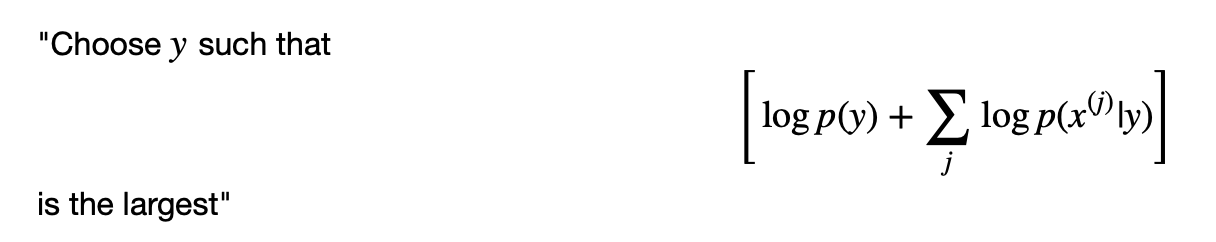

### To train the model, the following parameteres need to be learned:
##### Compute the Priors for each class
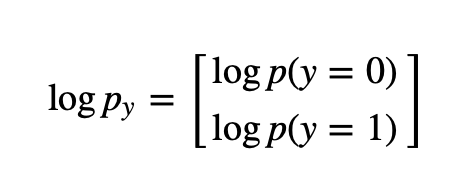

In [8]:
def log_prior(train_labels):
    """
    Function computes prior for each class, and returns a vector of shape (2,1)
    """
    
    labels = np.unique(train_labels)
    n_class = len(labels)
    log_py = np.zeros(n_class)

    for i in labels:
        log_py[i] = np.log((train_labels == i).sum() / len(train_labels))
        log_py = log_py.reshape(-1,1)
        
    assert log_py.shape == (2,1) 
    
    return log_py

In [9]:
# Performing sanity checks on implementation

log_py = log_prior(train_labels)
log_py

array([[-0.41610786],
       [-1.07766068]])

#### Compute the means for each feature, and produce a matrix of D by N Classes; In this case two

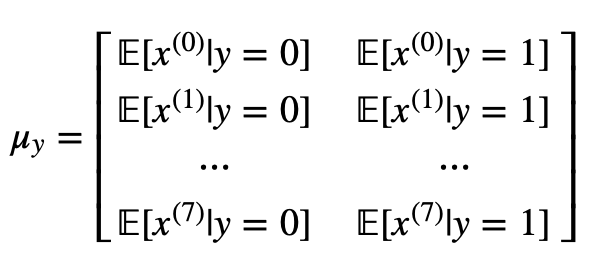

In [10]:
def cc_mean_ignore_missing(train_features, train_labels):
    """
    Function computes the means for each feature and by class, and returns a D by 2 matrix
    
    """
    
    N, d = train_features.shape
    labels = np.unique(train_labels)
    n_class = len(labels)
    mu_y = np.zeros((d, n_class ))
#   smoothing = 1e-4

    for i in labels:
        mu_y[:,i] = train_features[train_labels == i].mean(axis=0)
    
    assert mu_y.shape == (d, 2)
    return mu_y

In [11]:
# Performing sanity checks on implementation

mu_y = cc_mean_ignore_missing(train_features, train_labels)
mu_y

array([[   3.48641975,    4.91866029],
       [ 109.99753086,  142.30143541],
       [  68.77037037,   70.66028708],
       [  19.51358025,   21.97129187],
       [  66.25679012,  100.55980861],
       [  30.31703704,   35.1492823 ],
       [   0.42825926,    0.55279904],
       [  31.57283951,   37.39712919]])

#### Compute the standard deviation for each feature and by class
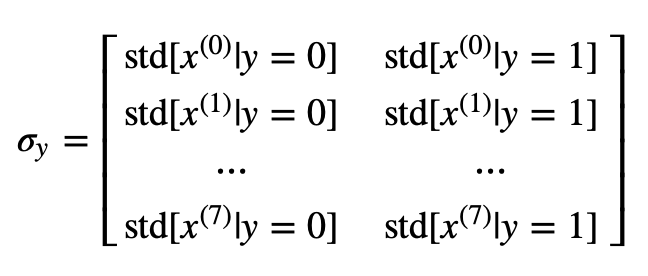

In [12]:
def cc_std_ignore_missing(train_features, train_labels):
    
    N, d = train_features.shape
    labels = np.unique(train_labels)
    n_class = len(labels)
    sigma_y = np.zeros((d, n_class))
  

    for i in labels:
        sigma_y[:,i] = train_features[train_labels == i].std(axis=0)
    
    
    assert sigma_y.shape == (d, 2)
    
    return sigma_y

In [13]:
sigma_y = cc_std_ignore_missing(train_features, train_labels)
sigma_y

array([[   3.1155426 ,    3.75417931],
       [  25.96811899,   32.50910874],
       [  18.07540068,   21.69568568],
       [  15.02320635,   17.21685884],
       [  95.63339586,  139.24364214],
       [   7.50030986,    6.6625219 ],
       [   0.29438217,    0.37201494],
       [  11.67577435,   11.01543899]])

#### Use the Gaussian Probability Distribution (PDF), 

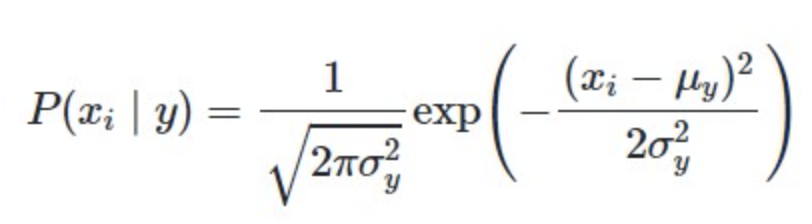

In [14]:
def log_prob(train_features, mu_y, sigma_y, log_py):
    
    N, d = train_features.shape
    
    """
    train_features = N * d
    train_labels   = N
    mu_y           =     d * 2
    sigma_y        =     d * 2
                   ------------
                     N * d * 2
    +
    log_py         
    
    """
    
    # Add fake axis for broadcasting
    train_features = train_features[:,:,np.newaxis]
    
    log_p_x_y = -0.5 * np.log(2 * np.pi * sigma_y**2) - ((train_features - mu_y)**2) / (2 * sigma_y**2) 
    log_p_x_y = log_p_x_y.sum(axis=1) + log_py.T
    
    
    assert log_p_x_y.shape == (N,2)
    return log_p_x_y

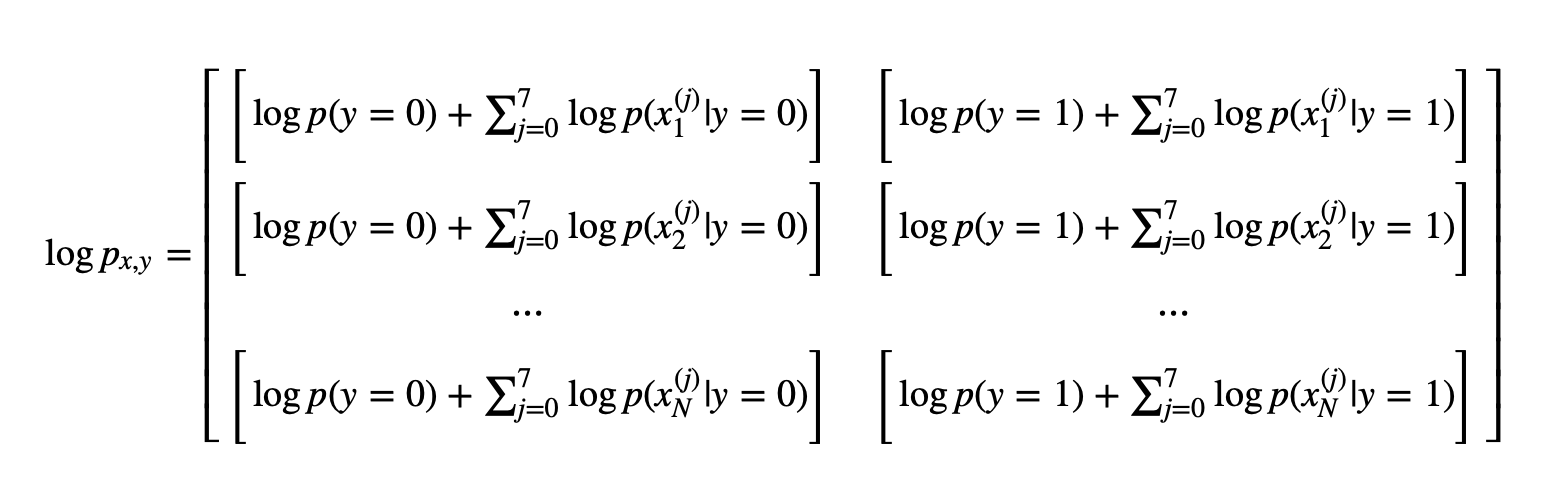

In [15]:
log_p_x_y = log_prob(train_features, mu_y, sigma_y, log_py)
log_p_x_y

array([[-26.96647828, -31.00418408],
       [-32.4755447 , -31.39530914],
       [-27.14875996, -31.51999532],
       ..., 
       [-26.29368771, -29.09161966],
       [-28.19432943, -30.08324788],
       [-26.98605248, -30.80571318]])

In [16]:
### Classifier Implementation

class NBClassifier():
    def __init__(self, train_features, train_labels):
        self.train_features = train_features
        self.train_labels = train_labels
#         self.log_py = log_prior(train_labels)
        self.log_py = self.get_cc_priors()
        self.mu_y = self.get_cc_means()
        self.sigma_y = self.get_cc_std()
     
    def get_cc_priors(self):
        log_py = log_prior(train_labels)
        return log_py
    
    def get_cc_means(self): 
        mu_y = cc_mean_ignore_missing(self.train_features, self.train_labels)
        return mu_y
        
    def get_cc_std(self):
        sigma_y = cc_std_ignore_missing(self.train_features, self.train_labels)
        return sigma_y
    
    def predict(self, features):
        y_hat = log_prob(features, self.mu_y, self.sigma_y, self.log_py)
        y_hat = np.argmax(y_hat, axis=1)
        return y_hat

In [17]:
diabetes_classifier = NBClassifier(train_features, train_labels)
train_predict = diabetes_classifier.predict(train_features)
eval_predict = diabetes_classifier.predict(eval_features)

In [18]:
train_accuracy_rate = (train_predict == train_labels).mean()
eval_predict_rate = (eval_predict == eval_labels).mean()

print(f'The accuracy % for the train set is: {train_accuracy_rate}')
print(f'The accuracy % for the evaluation set is: {eval_predict_rate}')

The accuracy % for the train set is: 0.7671009771986971
The accuracy % for the evaluation set is: 0.7532467532467533


#### Handling Missing Data

In [19]:
def cc_mean_consider_missing(train_features_with_nans, train_labels):
    N, d = train_features_with_nans.shape
    labels= np.unique(train_labels)
    n_class = len(labels)
    mu_y = np.zeros((d,n_class))
    
    for i in labels:
        mu_y[:,i] = train_features_with_nans[train_labels == i].mean(axis=0)

    assert mu_y.shape == (d, 2)
    return mu_y

In [20]:
mu_y = cc_mean_consider_missing(train_features_with_nans, train_labels)
mu_y

array([[   3.48641975,    4.91866029],
       [ 109.99753086,  142.30143541],
       [          nan,           nan],
       [          nan,           nan],
       [  66.25679012,  100.55980861],
       [          nan,           nan],
       [   0.42825926,    0.55279904],
       [  31.57283951,   37.39712919]])

In [21]:
def cc_std_consider_missing(train_features_with_nans, train_labels):
    
    N, d = train_features_with_nans.shape
    labels = np.unique(train_labels)
    n_class = len(labels)
    sigma_y = np.zeros((d,n_class))
    
    for i in labels:
        sigma_y[:,i] = train_features_with_nans[train_labels == i].mean(axis=0)
    
    
    assert sigma_y.shape == (d, 2)
    return sigma_y

In [22]:
sigma_y = cc_std_consider_missing(train_features_with_nans, train_labels)
sigma_y

array([[   3.48641975,    4.91866029],
       [ 109.99753086,  142.30143541],
       [          nan,           nan],
       [          nan,           nan],
       [  66.25679012,  100.55980861],
       [          nan,           nan],
       [   0.42825926,    0.55279904],
       [  31.57283951,   37.39712919]])

In [23]:
class NBClassifierWithMissing(NBClassifier):
    
    def get_cc_means(self):
        mu_y = cc_mean_consider_missing(self.train_features, self.train_labels)
        return mu_y
    
    def get_cc_std(self):
        sigma_y = cc_std_consider_missing(self.train_features, self.train_labels)
        return sigma_y

In [24]:
diabetes_classifier_with_nans = NBClassifierWithMissing(train_features_with_nans, train_labels)
train_predict_nans = diabetes_classifier_with_nans.predict(train_features_with_nans)
eval_predict_nans = diabetes_classifier_with_nans.predict(eval_features_with_nans)

In [25]:
train_accuracy_rate = (train_predict_nans == train_labels).mean()
eval_accuracy_rate = (eval_predict_nans == eval_labels).mean()
print(f'The train accuracy % with missing data is: {train_accuracy_rate}')
print(f'The evaluation accuracy % with missing data is: {eval_predict_rate}')

The train accuracy % with missing data is: 0.6596091205211726
The evaluation accuracy % with missing data is: 0.7532467532467533


Naive Bayes is an excelent algorithm to handle missing data, and removing those data items will not have any effect on the performance, unlike other classification algorithms. A traditional technique, but very powerful when classifying data.